# Fine-tuning

- 다양한 pretrained networks를 활용한 실험

- <span style='color:red'>주의사항</span>
    - 현재 설치되어있는 cuda 버전이 11.0이라서, 파이토치 1.7.1 버전까지만 설치가 가능하다.
    - cuda 버전을 바꾸어도 될 지 확인해보아야겠다.

In [2]:
from IPython.display import Image

## 실험 1: ResNet-18
- 데이터의 수가 많지 않기 때문에, pretrained된 resnet 18 모델을 활용한다.
- resnet은 imagenet 데이터로 학습되었는데, 대회 데이터인 마스크 데이터셋과는 차이가 있기 때문에
resnet 또한 최적화한다.
- 결과적으로 resnet18을 backbone으로 설정하고, classifier를 basemodel로 만든 뒤 학습시킨다.

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_test",
}
```

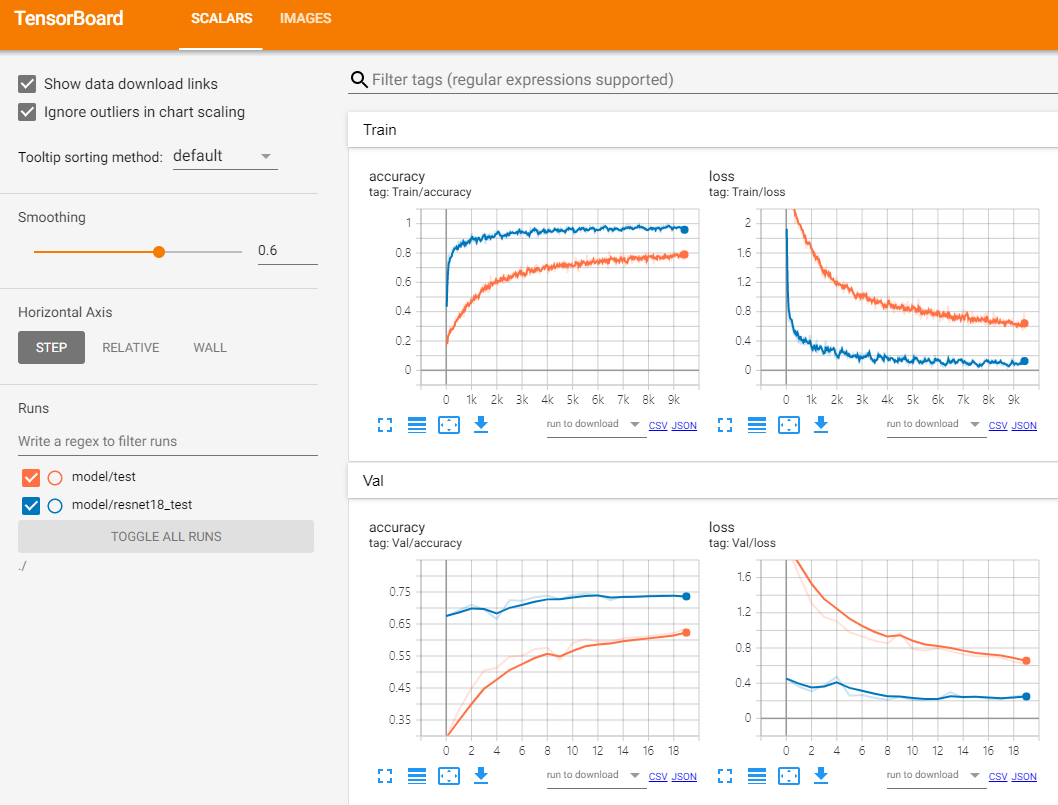

In [3]:
Image(filename="/opt/ml/experiment-results/v3_resnet18.PNG")

**[변경사항]**
- 비교군: baseline_v2의 exp8, resent18
- resnet18의 마지막 fc layer를 1000 -> 18(=num_classes)로 변경하였음.

**[결과]**
- baseline_v2에서 가장 좋은 성능을 보이는 모델과 비교했을 때, validation accuracy 기준 10% 가량의 성능 향상이 나타났다.
- 제출했을 때, test acc 기준 10% 가량의 성능 향상이 나타났다.

**[분석]**
- 우선 데이터의 수가 적기 때문에 resnet18 모델로도 충분한 표현력을 가질 수 있다고 생각했고, baseline_v2와 비교했을 때 꽤나 성능이 향상되었다.
- 다만 training acc와 val acc를 비교했을 때 차이가 심했고, 이는 overfitting을 의심할 수 밖에 없었다.
    - 20 에폭 밖에 돌리지 않았음에도 training acc 기준 95% 까지 달성했고, val acc는 73% 정도 찍혔다.
    - val acc에 비해서 training acc만 비정상적으로 높았던 것을 보아, overfitting이 의심된다.
    - 다만 training data에 overfitting이 일어났던 점은 data의 수가 너무 적었기 때문이라고 생각한다.
    - 또한 training data와 val data를 split할 때, class의 분포는 고려하지 않은 채로 나누었기 때문에 이러한 현상이 심화되었다고 생각한다.
- ImageNet의 모든 데이터를 알 수는 없지만, 사람의 얼굴 혹은 마스크를 착용한 사람의 얼굴 데이터는 거의 없을 것으로 생각한다.
    - 다만 종류가 다른 데이터라고 해도, randomly initialized weight 보다는 pretrained weight가 성능 측면에서 좋기도 하고, 또한 모든 parameters를 tuning했기 때문에 최소한의 성능은 나타난 것으로 보여진다.

**[계획]**
- fold 방식을 이용해서, 학습에 사용할 수 있는 데이터를 최대한 활용하는 방식으로 접근한다.
- train/validation split을 클래스 간 분포가 어느 정도 맞게 분리해본다.

## 실험 2: ResNet-18 with original resnet input size(224 x 224)
**[계획]**
- pretrained network를 사용할 때 정말 중요한 것은, 해당 모델을 학습시킬 때의 방식을 동일하게 가져가는 것이다.
- 대표적으로는 입력 이미지의 사이즈가 있고, 이미지를 normalize하는 수치 또한 중요할 수 있다.
- 일단은 이미지 사이즈를 원래 resnet paper의 224 x 224로 resize해준 뒤 학습을 시켜보았다.


```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [ # caution!
        224,
        224
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_imagenetsize",
    "data_dir": "/opt/ml/input/data/train/images",
    "model_dir": "./model"
}
```

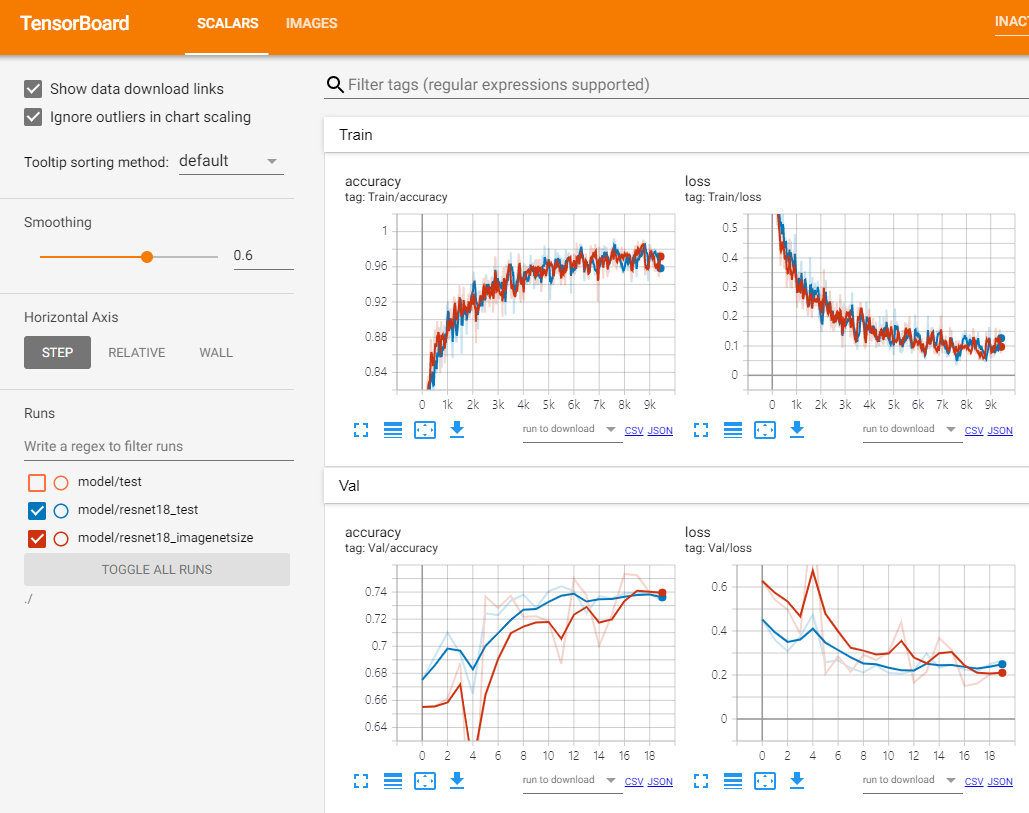

In [5]:
Image(filename="/opt/ml/experiment-results/resnet18/v3_resnet18_224by224.PNG")

**[변경사항]**
- 비교군: resnet18, resnet18 with 224 x 224 size
- resnet18에 입력되는 이미지 사이즈를 128 x 96에서 224 x 224로 변경하였음.

**[결과]**
- resnet18과 비교했을 때 val acc가 1% 정도 높았다.
- 재밌었던 사실은 submission을 했을 때 resnet18보다 f1은 0.5, accuracy는 6% 가량 향상되었다는 점이었다.

**[분석]**
- 첫 번째로 눈에 띄는 차이점은, train/val 모두 acc/loss 측면에서 <span style='color:lightblue'>oscillation(진동)이 많이 발생했다</span>는 점이다.
    - 아무래도 입력 이미지의 크기가 훨씬 커졌으니(3 x 224 x 224 - 3 x 128 x 96 = 113,664. 한 장의 이미지 당 11만 개의 추가 픽셀 정보가 생긴 것),
    보다 학습이 불안정했던 것이 아닐까 생각한다.
- training acc와 val acc가 같이 상승하는 모습이긴 하지만, training acc는 95%에 달하는 정확도를 보이는 반면에 val acc는 70% 중반 정도를 보인다는 것은,
overfitting이라고도 해석가능하지만 이보다는 <span style='color:orange'>training data와 validation data 간의 클래스 불균형</span>이 일어났다고 해석할 수 있다.
    - train/val dataset을 단순히 80:20으로 나누기 때문에, 클래스의 분포가 고르게 되어있지 않다.
    - train/val dataset의 클래스 분포가 유사하지 않다면, 위 그래프와 같이 training acc는 비정상적으로 높고 val acc는 낮게 나올 수 있다.
    결국 모델은 train data로부터 얻은 gradient로 최적화되기 때문에, train에 없는 data들이 val에 많다면 val acc가 낮을 수 밖에 없다.
    - train/val의 클래스 분포가 유사하도록 data를 split해야 한다.
- 성능이 높아진 이유로는, 확실하진 않지만 2가지 정도 떠오른다.
    - 첫 번쨰는 정보가 많아졌다는 점이다(이는 어느정도 확실한 것 같다).
    - 두 번째는 pretrained resnet18 모델이 224 x 224 사이즈의 이미지로 학습된 모델이기 때문에, 동일한 모양을 가지는 이미지를 입력받았을 때
    기존 학습되어있던 정보를 보다 잘 활용할 수 있었겠다고 생각한다(불확실하다).

**[계획]**
- fold 방식을 이용해서, 학습에 사용할 수 있는 데이터를 최대한 활용하는 방식으로 접근한다.
- train/validation split을 클래스 간 분포가 어느 정도 맞게 분리해본다.
- 원본 이미지를 바로 224 x 224로 resize하지 말고, centercrop과 같은 preprocessing을 거쳐 유의미한 정보만 추출한 뒤 resize해본다.
- Adam을 쓰니 너무 빠르게 수렴하는 것 같은데, 대회 게시판에 다른 캠퍼분이 올려주신 것을 보니 보다 단순한 optimizer를 써보아도 좋을 것 같다.

## 실험 3: ResNet-18 with reduced LR
**[계획]**
- 학습 과정의 그래프를 보았을 때 진동이 많이 발생하는 것 같아서, learning rate를 1/10로 줄여 보다 안정적으로 학습이 이루어지게끔 한다.

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        224,
        224
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.0001,   # 0.001 -> 0.0001로 변경
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_originalsize_reducelr",
}
```

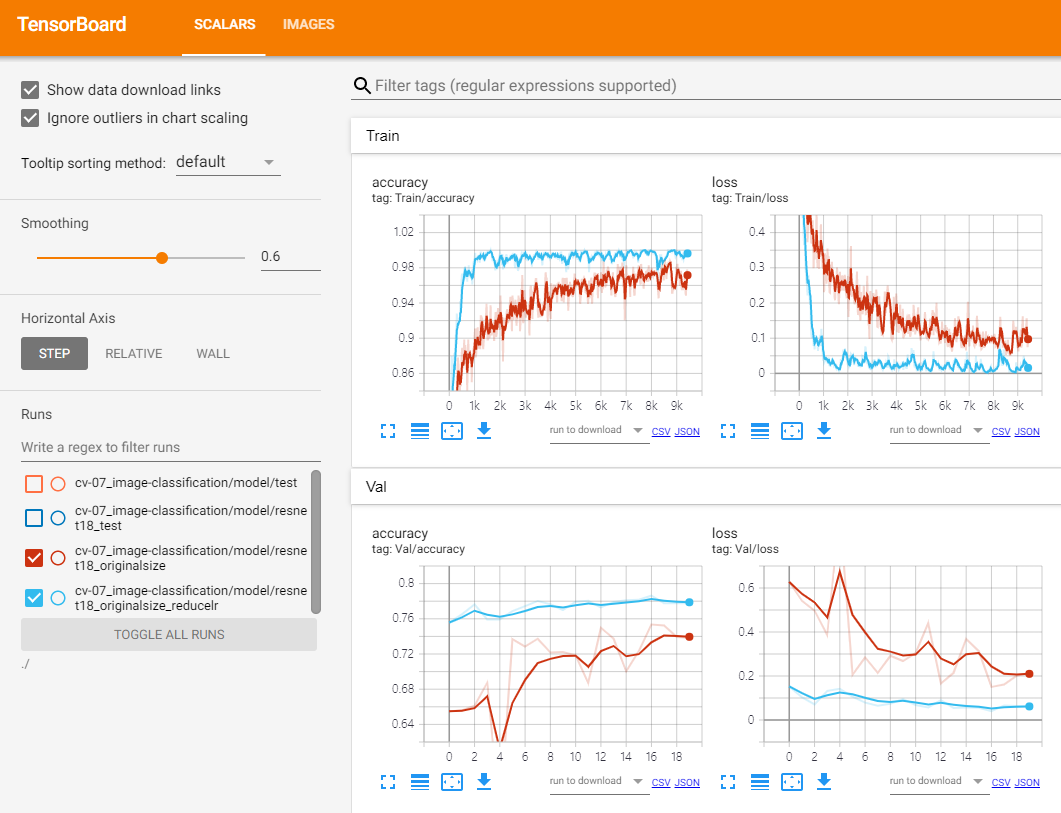

In [4]:
Image(filename="/opt/ml/experiment-results/resnet18/v3_resnet18_reducelr.PNG")

**[변경사항]**
- 비교군: resnet18 with 224 x 224 size, resnet18 with 224 x 244 and lr=0.0001
- resnet18의 parameters를 최적화하는 Adam의 learning rate를 0.001 에서 0.0001로 1/10만큼 감소시켰음.

**[결과]**
- learning rate를 1/10 감소시켰을 때 train/val loss/acc 측면에서 큰 성능 향상이 일어났다.
- submission 결과 f1 score는 0.05 정도, acc는 4% 정도 향상되었다.
- 학습 초기부터 수렴하는 모습을 보여주었으며, 특이사항으로는 <span style='color:orange'>training acc가 100%</span> 였다는 점이다.

**[분석]**
- train/val data 모두에 수렴하는 모습을 보여주었으나, 그래프를 보면 알 수 있듯이 val acc/loss는 saturation되는 모습이 나타난다.
    - 이는 앞선 실험에서 언급했던 <span style='color:orange'>train/val data 간의 클래스 분포 불균형</span>때문이라고 해석가능하다.
    - 모델은 train data를 기반으로 최적화되기 때문에 train data를 잘 맞출 수 있도록 최적화된다.
    - 만약 val data의 분포가 train data와 유사하다면, val acc/loss 역시 train acc/loss의 양상을 따라가야 한다.
    - 하지만 val data에 대한 모델의 예측 성능은 saturation된 모습이고, 이는 train/val data가 서로 다르다고 해석가능하다(train data에 없는 data들이 val data에 많다는 것).
    - 실험 세팅을 더 이상 변경하지 않아도, 데이터 split만 균형있게 한다면 모델의 일반화 성능이 높아질 것으로 예상한다. -> <span style='color:orange'>f1 score가 낮게 측정된 것도</span> train/val data의 클래스 분포가 다르기 때문이라고 생각한다.
- Adam 기준 lr을 0.0001로 세팅했을 때 상당히 수렴이 잘 되는 모습이다.
    - 이전 실험의 lr은 모델을 완전히 최적화하기에는 너무 큰 값이었을 수 있겠다.
    - 하지만 데이터를 다른 방식으로 split한다면, 또 다른 lr이 최적의 값일 수 있기 때문에 그 때 다시 탐색해볼 필요가 있다.

**[계획]**
- 모델의 성능은 f1 score로 평가되는데, f1 score를 어떻게 하면 올릴 수 있을지 metric을 분석해볼 생각이다.
- 입력 이미지를 normalize하는 값들에 대해서도 고민을 해봐야할 것 같다.

## Metric: F1 Score

## 실험 4: ResNet-18 with K-Fold strategy
**[계획]**
- 앞선 실험으로, training data에는 overfitting 되었지만 validation data에 대해서는 낮은 성능을 보인다는 결과를 확인했다.
- 이는 현재 split 방식이, 사용자가 지정한 val_ratio에 맞게 random으로 분리하고 있기 때문이다.
    - random이긴 하지만 seed를 설정했기 때문에, seed 값을 변경하지 않는 이상 똑같은 train/val data로 분리한다.
- 이러한 문제점을 해소하기 위해서, 데이터가 한정적일 때 모든 데이터를 학습에 활용하면서도 모델 성능을 평가할 수 있는 fold stategy를 사용해본다.
- fold에는 k-fold, stratified-fold, group-fold 등이 있다. 일반적으로 imbalanced data에 대해서는 stratified-fold가 좋지만, k-fold부터 차례대로 실험하면서 실제 효과를 확인해보는 것이 목적이다.
- 현재 fold train 코드를 작성 중인데, fold의 개수만큼 모델이 만들어지고 이를 ensemble해야 하는데
<span style='color:orange'>어떻게 ensemble할 지</span>를 몰라서 찾아보고 있는 중이다.
    - 찾아보니 classification 모델들을 ensemble할 때는 기본적으로 <span style='color:orange'>voting 알고리즘</span>을 사용한다고 한다.
    - voting에는 hard voting과 soft voting이 있다.
    - hard voting은 모델들이 예측한 결과 중에서 가장 높은 빈도로 등장한 예측값을 최종 결과로 선택하는 것이다.
    - soft voting은 모델들이 예측한 결과들의 확률에 대한 평균을 최종 결과로 선택한다고 한다.
    - 일반적으로 soft voting이 성능이 더 좋다고 하는데, soft voting 개념이 명확하게 이해되지 않아서 좀 더 공부해야할 것 같다.

```python
{
    "seed": 42,
    "epochs": 5,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        224,
        224
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.0001,
    "mode": "k",
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_kfold",
}
```

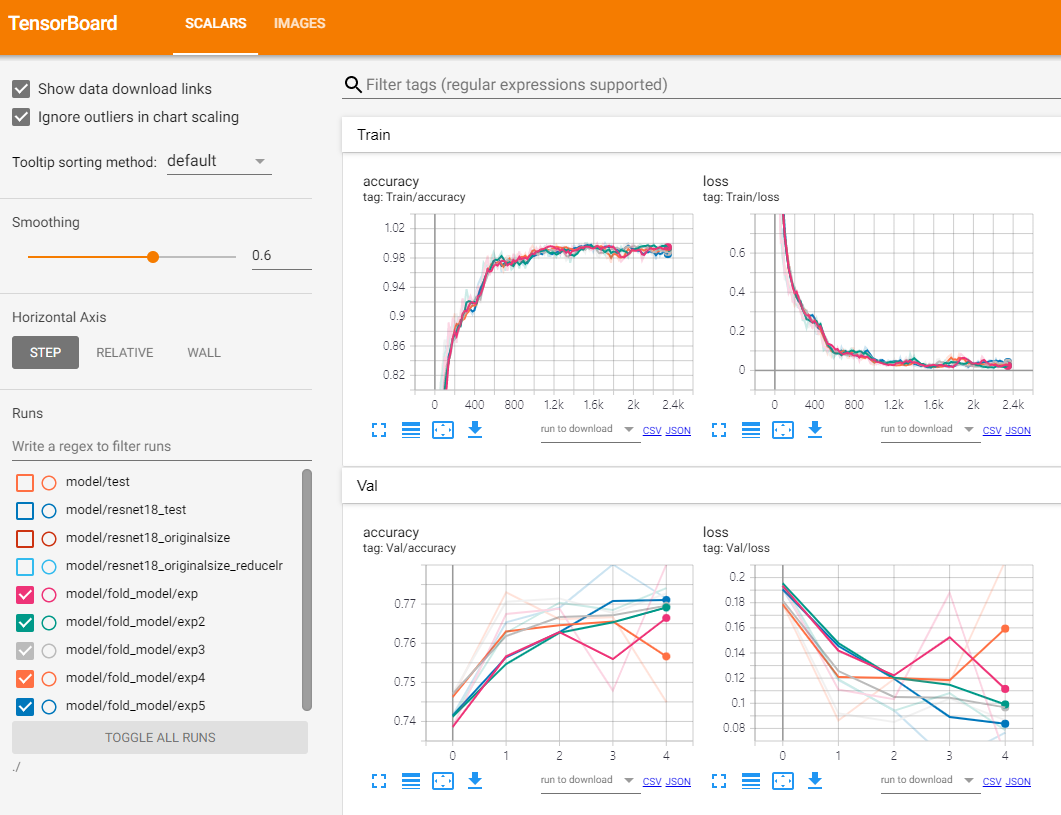

In [2]:
Image(filename="/opt/ml/experiment-results/resnet18/v4_resnet18_with_kfold.PNG")

**[변경사항]**
- 비교군: resnet18 with 224 x 224 and lr=0.0001, 똑같은 setting에서 k-fold(k=5) 적용
- fold의 개수만큼 모델이 만들어졌으며, 이를 ensemble하여 최종 결과를 결정.

**[결과]**
- 5개의 모델 모두 validation error는 70% 중반에서 머물렀다.
- submission 결과 f1 score는 0.02 정도, acc는 0.6% 정도 향상되었다.

**[분석]**
- 아무래도 5개 모델의 예측 결과를 합쳐 최종 결과를 출력했기 때문에, 성능이 조금 더 나았다.
- 다만 k-fold 역시 클래스의 분포를 고려하지 않고 fold를 만들기 때문에, 성능 향상이 크진 않았다.
    - 만약 클래스의 분포를 고려해서 fold를 만든다면 어떻게 될까?
    - 아무래도 train과 validation 모두 다양한 클래스에 대한 데이터를 가지고 있으므로 generalization 성능이 높아질 것이다.
    - 하지만 현재 데이터는 불균형이 매우 심하기 때문에, 분포를 고려해서 fold를 만든다고 해도 특정 클래스 위주로 모델이 학습될 가능성이 높다.
    - 만약 train/val data에는 수가 적은 클래스가 test data에 극단적으로 많다고 한다면, train/val에 대해 최적화된 모델의 성능은 낮을 수 밖에 없다.
    - 결국 <span style='color:orange'>fold를 적용하기 이전에, training data의 클래스들 간 불균형을 해결할 필요성이 있다.</span>

**[계획]**
- class imbalance를 해결할 수 있는 data augmentation 기법을 찾아보아야할 것 같다.
- dataset 차원에서 imbalance를 어느 정도 해결한다면, focal loss 등을 적용해서 학습해볼 수 있겠다.

## 실험 5: ResNet-18 with Focal Loss(gamma=2. & 5.)
**[계획]**
- Training data의 imbalance 문제를 해결하기 위해서 data를 건드리거나, regularization을 적용해볼까 생각했는데 focal loss가 regularization 중 하나라는 생각이 들어 적용해보았다.
- 오답에 대한 gradient를 키워서, 오분류된 데이터에 대해서도 잘 예측할 수 있도록 한다.
    - 생각해보니 오분류된 데이터에 대한 gradient를 키워서 fitting을 하려면 train/val data split을 균형있게 해야하는데,,,

```python
{    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        224,
        224
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.0001,
    "mode": "plain",
    "val_ratio": 0.2,
    "criterion": "focal",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_originalsize_reducelr_focal",}
```

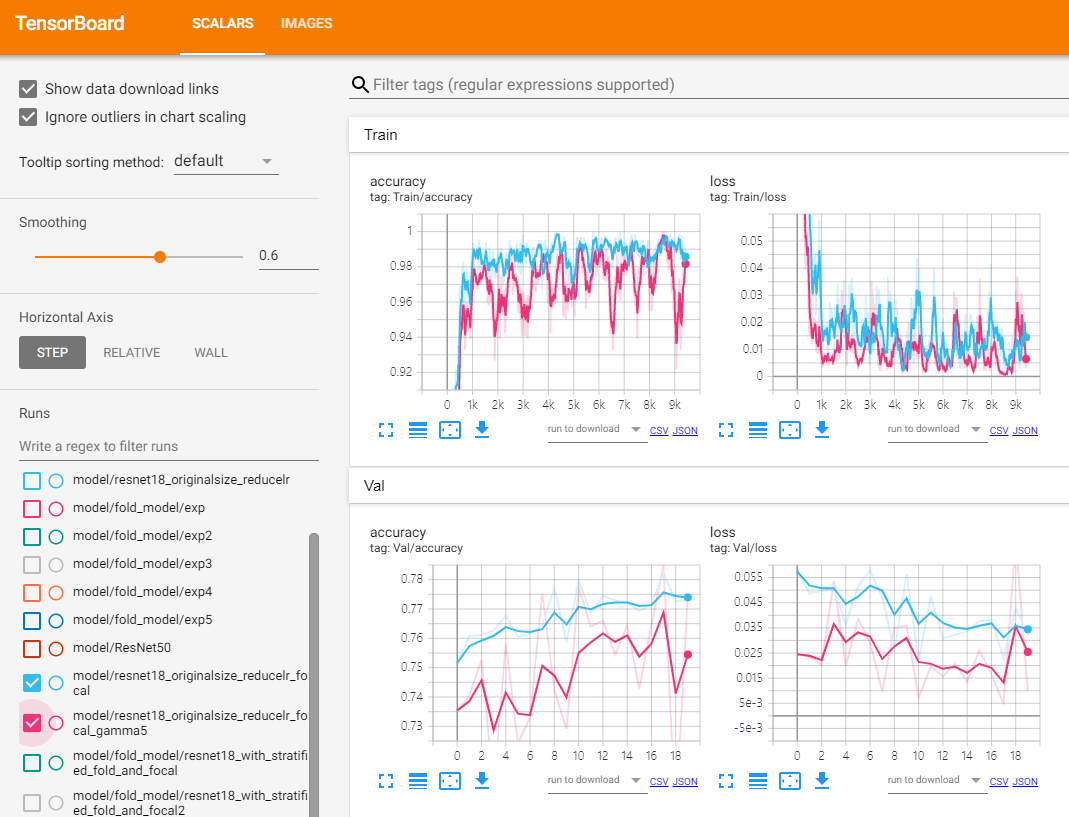

In [3]:
Image(filename="/opt/ml/experiment-results/resnet18/v4_resnet18_with_focalloss.PNG")

**[변경사항]**
- 비교군: resnet18 with 224 x 224 and lr=0.0001, 해당 세팅에서 focal loss의 gamma값만 2와 5로 설정

**[결과]**
- gamma 2일 때 모델의 성능이 보다 좋았고, 비교적 안정적이기도 했다.
- 오답에 대한 gradient를 크게 주기 때문에, loss와 acc 모두 크게 진동하는 모습이었다.

**[분석]**
- 분석할 내용이 없다.

**[계획]**
- 과연, resnet18이 최적의 아키텍처일까,, 확인해볼 필요가 있다.
- 슬슬 데이터를 건드려 볼 시점이 온 것 같다.

## 실험 6: ResNet-18 + stratified-k-fold + Focal Loss(gamma=5.)
**[계획]**
- focal loss 실험을 통해 떠올렸던 것은, 아무리 focal loss로 오답에 대한(train에서 비교적 작은 수의 샘플) gradient를 크게 update한다 한들,
train/val data의 분포 자체가 다르다면 update하는 의미가 없다고 생각했다.
- 이를 stratified-k-fold로 해결하고자 했고, 그와 더불어 focal loss를 적용하여 적은 수의 데이터에 대해 예측한 오답을 크게 penalize하고자 하였다.

```python
{    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        224,
        224
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "ResNet18",
    "optimizer": "Adam",
    "lr": 0.0001,
    "mode": "s",
    "val_ratio": 0.2,
    "criterion": "focal",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "resnet18_with_stratified_fold_and_focal(gamma=5)",}
```

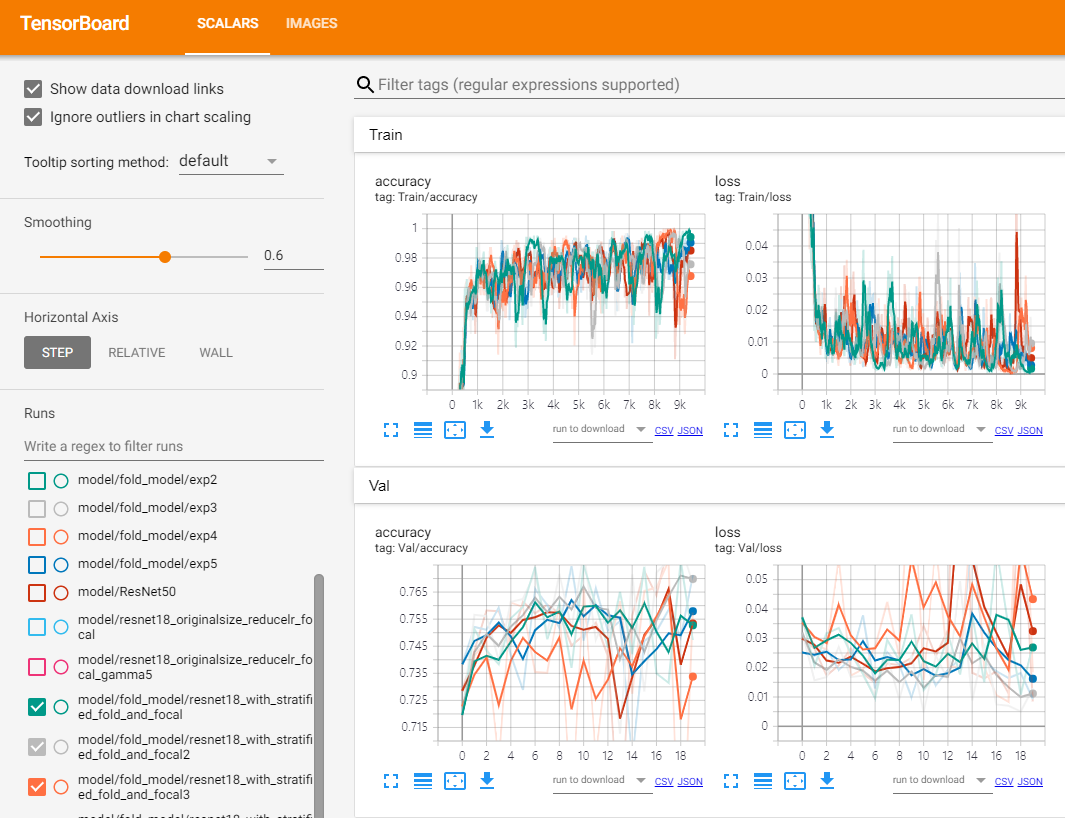

In [4]:
Image(filename="/opt/ml/experiment-results/resnet18/v4_resnet18_with_stratified_fold_and_focalloss_gamma5.PNG")

**[변경사항]**
- resnet18 + stratified-fold + lr 0.0001 + focal_loss(gamma=5)

**[결과]**
- 찍히는 validation acc 자체는 높아졌지만, 실제 submission을 했을 때 acc는 아주 조금 감소했고, f1 score는 더 감소했다.

**[분석]**
- gamma 값이 너무 컸던 것 같다. 학습이 안정적으로 되지 않았다.

**[계획]**
- 똑같은 setting에서 gamma 값을 2로 낮추어 보거나, cross-entropy loss로 변경해본다.

In [ ]:
## 추가로 할 거: 얼굴 데이터셋에 학습된 backbone network를 가져다가 성능 측정해보기

당장 할 거: fold 방식으로 학습시키기 + f1 score 공부하기